In [25]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

In [26]:
train_df=pd.read_csv("DailyDelhiClimateTrain.csv")
print(len(train_df))

1462


In [27]:
train_df.shape

(1462, 5)

In [28]:
train_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [29]:
train_df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


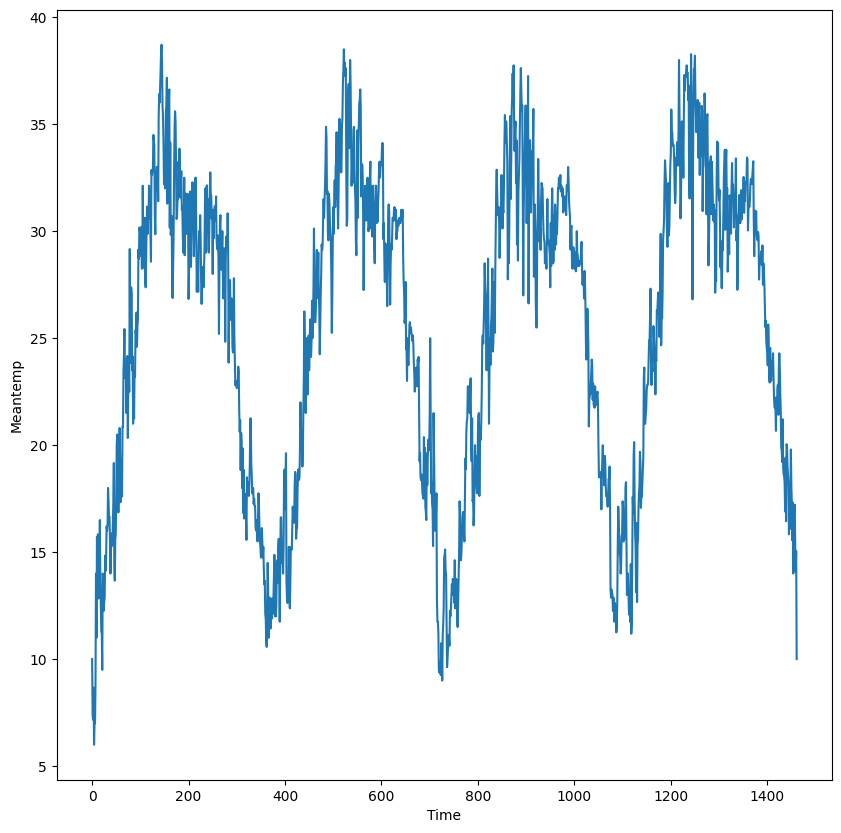

In [30]:
fig,ax=plt.subplots(figsize=(10,10))
ax.plot([i for i in range(len(train_df['meantemp']))],train_df['meantemp'])
ax.set_xlabel("Time")
ax.set_ylabel("Meantemp")
plt.show()

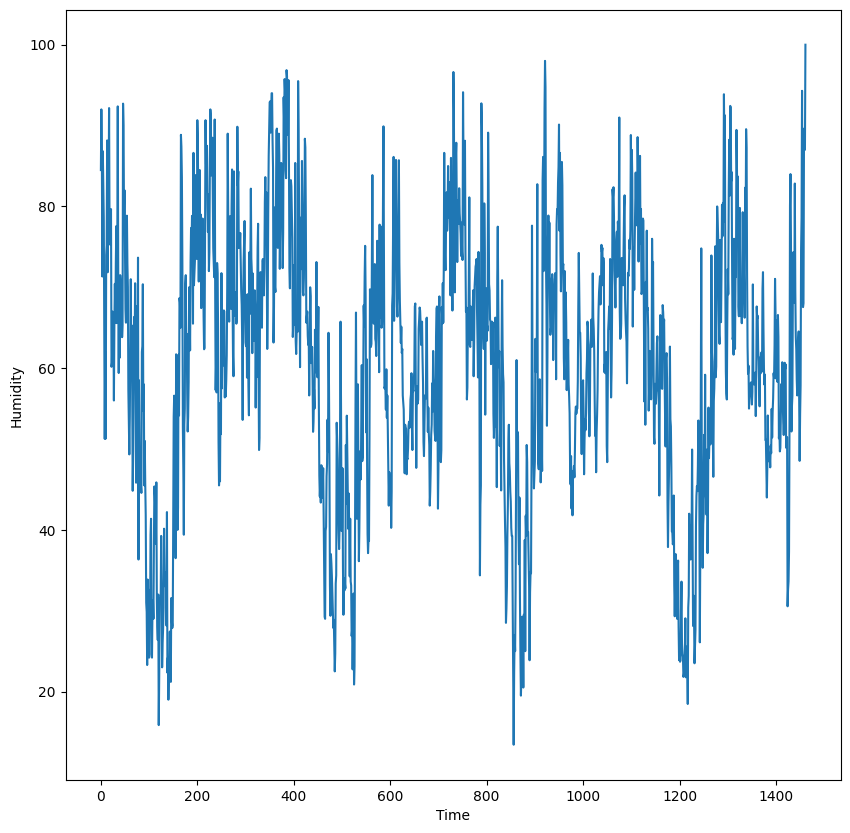

In [31]:
fig,ax=plt.subplots(figsize=(10,10))
ax.plot([i for i in range(len(train_df['humidity']))], train_df['humidity'])
ax.set_xlabel('Time')
ax.set_ylabel('Humidity')
plt.show()

In [32]:
scaler=MinMaxScaler()
meantemp=scaler.fit_transform(train_df['meantemp'].values.reshape(-1,1))
humidity=scaler.fit_transform(train_df['humidity'].values.reshape(-1,1))

In [33]:
meantemp.shape

(1462, 1)

In [34]:
def X_y_split(data, time_step=12):
  X=[]
  y=[]
  for i in range (len(data)-time_step):
    X.append(data[i:i+time_step])
    y.append(data[i+time_step])
  X=np.array(X)
  y=np.array(y)
  return X,y

In [35]:
X,y=X_y_split(meantemp, time_step=12)

In [36]:
X.shape, y.shape

((1450, 12, 1), (1450, 1))

In [37]:
def train_test_split(X,y,shuffle=True, percentage=0.8):
    if shuffle:
        random_num=[index for index in range(len(X))]
        np.random.shuffle(random_num)
        X=X[random_num]
        y=y[random_num]
    split_num=int(len(X)*percentage)
    train_X=X[:split_num]
    train_y=y[:split_num]
    test_X=X[split_num:]
    test_y=y[split_num:]
    return train_X,train_y,test_X,test_y

In [38]:
train_X,train_y,test_X,test_y=train_test_split(X,y,shuffle=False, percentage=0.8)

In [39]:
X_train,y_train=train_X,train_y

In [40]:
class CNN_LSTM(nn.Module):
    def __init__(self, conv_input,input_size, hidden_size, num_layers, output_size):
        super(CNN_LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv=nn.Conv1d(conv_input,conv_input,1)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x=self.conv(x)
        h0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size)
        #print(f"x.shape:{x.shape},h0.shape:{h0.shape},c0.shape:{c0.shape}")
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [41]:
%%time

test_X1=torch.Tensor(test_X)
test_y1=torch.Tensor(test_y)


input_size = 1
conv_input=12
hidden_size = 64
num_layers = 5
output_size = 1


model =CNN_LSTM(conv_input,input_size, hidden_size, num_layers, output_size)


num_epochs=500
batch_size=64

optimizer=optim.Adam(model.parameters(),lr=0.0001,betas=(0.5,0.999))

criterion=nn.MSELoss()

train_losses=[]
test_losses=[]

print(f"start")

for epoch in range(num_epochs):

    random_num=[i for i in range(len(train_X))]
    np.random.shuffle(random_num)

    train_X=train_X[random_num]
    train_y=train_y[random_num]

    train_X1=torch.Tensor(train_X[:batch_size])
    train_y1=torch.Tensor(train_y[:batch_size])


    model.train()

    optimizer.zero_grad()

    output=model(train_X1)

    train_loss=criterion(output,train_y1)

    train_loss.backward()

    optimizer.step()

    if epoch%50==0:
        model.eval()
        with torch.no_grad():
            output=model(test_X1)
            test_loss=criterion(output,test_y1)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"epoch:{epoch},train_loss:{train_loss},test_loss:{test_loss}")

start
epoch:0,train_loss:0.4072154760360718,test_loss:0.6074012517929077
epoch:50,train_loss:0.1834513545036316,test_loss:0.2993795871734619
epoch:100,train_loss:0.05559336766600609,test_loss:0.048056140542030334
epoch:150,train_loss:0.0518522635102272,test_loss:0.05341128259897232
epoch:200,train_loss:0.042480338364839554,test_loss:0.047133669257164
epoch:250,train_loss:0.038791872560977936,test_loss:0.05186384171247482
epoch:300,train_loss:0.04143095016479492,test_loss:0.03439278155565262
epoch:350,train_loss:0.011624143458902836,test_loss:0.00866862665861845
epoch:400,train_loss:0.004436069633811712,test_loss:0.0038886198308318853
epoch:450,train_loss:0.004099734127521515,test_loss:0.004180266056209803
CPU times: user 17.3 s, sys: 60.9 ms, total: 17.4 s
Wall time: 17.5 s


In [42]:
def mse(pred_y,true_y):
    return np.mean((pred_y-true_y) ** 2)

In [43]:
train_X1=torch.Tensor(X_train)
train_pred=model(train_X1).detach().numpy()
test_pred=model(test_X1).detach().numpy()
pred_y=np.concatenate((train_pred,test_pred))
pred_y=scaler.inverse_transform(pred_y).T[0]
true_y=np.concatenate((y_train,test_y))
true_y=scaler.inverse_transform(true_y).T[0]
print(f"mse(pred_y,true_y):{mse(pred_y,true_y)}")

mse(pred_y,true_y):34.1368249347045


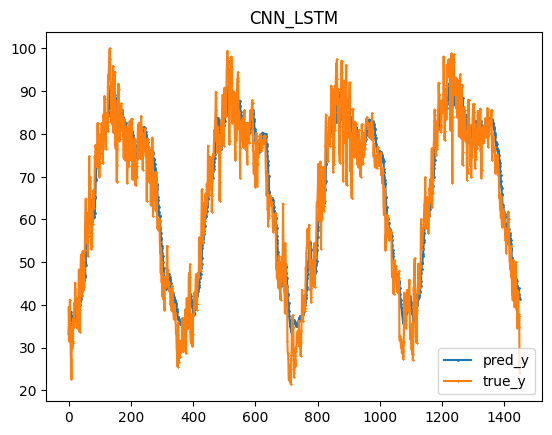

In [44]:
plt.title("CNN_LSTM")
x=[i for i in range(len(true_y))]
plt.plot(x,pred_y,marker="o",markersize=1,label="pred_y")
plt.plot(x,true_y,marker="x",markersize=1,label="true_y")
plt.legend()
plt.show()